***
## 0. Import

In [1]:
import GAN
from GAN import *

import gc
import hdbscan
import importlib
import io
import math
import numpy as np
import operator
import pandas as pd
import psutil
from matplotlib import pyplot as plt

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, OrdinalEncoder, LabelEncoder

***
## 1. Read Data

In [2]:
data = pd.read_excel('ed_pred.xlsx')
data = data.reset_index()
data.head()

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

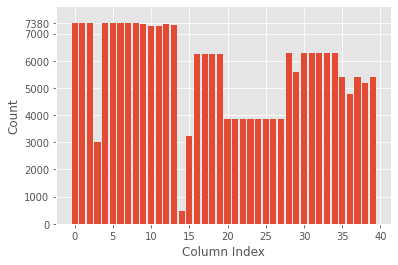

In [21]:
buf = io.StringIO()
data.info(buf=buf)
information = buf.getvalue().split('\n')

non_null_count = []
for i in range(5, 45):
    row = information[i].split()
    non_null_count.append(int(row[2]))

plt.bar([i for i in range(len(non_null_count))], non_null_count)
plt.ylim(0, 8000)
plt.yticks([i for i in range(0, 8000, 1000)] + [7380])
plt.xlabel('Column Index')
plt.ylabel('Count')
plt.savefig('non_null_count.png')
plt.show()

In [6]:
data.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [7]:
data.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


Detected:	470,	6.37%
None Detected:	6910,	93.63%
Invalid Data:	0,	0.00%


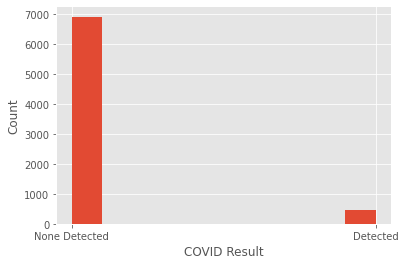

In [25]:
detected_count = 0
non_detected_count = 0
invalid_count = 0
for i in data[['COVIDResult']].values:
    if i == "Detected":
        detected_count += 1
    elif i == "None Detected":
        non_detected_count += 1
    else:
        invalid_count += 1

total_count = detected_count + non_detected_count + invalid_count 
print("Detected:\t{},\t{:.2f}%".format(detected_count, detected_count * 100.0 / total_count))
print("None Detected:\t{},\t{:.2f}%".format(non_detected_count, non_detected_count * 100.0 / total_count))
print("Invalid Data:\t{},\t{:.2f}%".format(invalid_count, invalid_count * 100.0 / total_count))

plt.hist(data[['COVIDResult']].values)
plt.xlabel('COVID Result')
plt.ylabel('Count')
plt.savefig('original_label_distribution.png')
plt.show()

***
## 2. Preprocess

### 2.0 Prepare

In [26]:
label_cols = ['COVIDResult']
cat_cols = ['AdmittingDepartment', 'FirstRace', 'Ethnicity', 'Sex']
num_cols = list(data.columns[data.columns != 'COVIDResult'])
for i in cat_cols:
    num_cols.remove(i)

train, test = train_test_split(data, test_size = 0.2)

### 2.1 StandardScaler Analysis

In [27]:
def numerical_imputer_preprocess(x_num):
    for i in range(len(x_num)):
        for j in range(len(x_num[i])):
            if isinstance(x_num[i][j], str):
                if (ord('0') <= ord(x_num[i][j][0]) <= ord('9')):
                    x_num[i][j] = float(x_num[i][j])
                else:
                    x_num[i][j] = float(x_num[i][j][1:])
                    
    imp = SimpleImputer(strategy='constant', fill_value=0)
    x_num = imp.fit_transform(x_num)
    
    return x_num

x_num = train.drop(label_cols + cat_cols, axis=1).values
x_num = numerical_imputer_preprocess(x_num)

scaler = StandardScaler()
x_num = scaler.fit_transform(x_num)

x_num = x_num.transpose()
print("Negative values count after StandardScaler")
total = x_num.shape[1]
for i in range(0, x_num.shape[0]):
    count = 0
    for j in x_num[i]:
        if j < 0:
            count += 1
    
    print('Column {}: {}/{}, {:.2f}%'.format(i, count, total, count * 100.0 / total))

Negative values count after StandardScaler
Column 0: 2947/5904, 49.92%
Column 1: 2947/5904, 49.92%
Column 2: 3478/5904, 58.91%
Column 3: 2761/5904, 46.76%
Column 4: 3251/5904, 55.06%
Column 5: 3190/5904, 54.03%
Column 6: 3047/5904, 51.61%
Column 7: 1811/5904, 30.67%
Column 8: 3954/5904, 66.97%
Column 9: 5550/5904, 94.00%
Column 10: 3611/5904, 61.16%
Column 11: 3311/5904, 56.08%
Column 12: 1804/5904, 30.56%
Column 13: 1955/5904, 33.11%
Column 14: 2777/5904, 47.04%
Column 15: 3576/5904, 60.57%
Column 16: 4332/5904, 73.37%
Column 17: 3666/5904, 62.09%
Column 18: 3718/5904, 62.97%
Column 19: 4454/5904, 75.44%
Column 20: 4332/5904, 73.37%
Column 21: 3363/5904, 56.96%
Column 22: 4332/5904, 73.37%
Column 23: 881/5904, 14.92%
Column 24: 1570/5904, 26.59%
Column 25: 960/5904, 16.26%
Column 26: 1626/5904, 27.54%
Column 27: 3910/5904, 66.23%
Column 28: 4230/5904, 71.65%
Column 29: 3861/5904, 65.40%
Column 30: 4539/5904, 76.88%
Column 31: 4465/5904, 75.63%
Column 32: 3429/5904, 58.08%
Column 33: 1

### 2.2 Preprocessing

In [28]:
def numerical_scaler_preprocess(x_num):
    scaler = StandardScaler()
    x_num = scaler.fit_transform(x_num)
    
    for i in range(x_num.shape[0]):
        for j in range(x_num.shape[1]):
            if x_num[i][j] < 0:
                x_num[i][j] = 0
    
    return x_num

def numerical_normalizer_process(x_num):
    norm = Normalizer()
    x_num = norm.fit_transform(x_num)
    return x_num

def numerical_preprocess(x_num):
    x_num = numerical_imputer_preprocess(x_num)
#     x_num = numerical_scaler_preprocess(x_num)
    x_num = numerical_normalizer_process(x_num)
    
    return x_num
    
def categorical_preprocess(x_cat):
    for i in range(len(x_cat)):
        if not isinstance(x_cat[i][0], str):
            x_cat[i][0] = 'NA'
        if not isinstance(x_cat[i][1], str):
            x_cat[i][1] = '*Unspecified'
            
    oe = OrdinalEncoder()
    x_cat = oe.fit_transform(x_cat)
    
    return x_cat
    
def y_preprocess(y):
    le = LabelEncoder()
    y = le.fit_transform(y)
    for i in range(len(y)):
        y[i] = 1 - y[i]
    
    return y

def preprocess(data):
    data = data.drop(['index', 'patno'], axis=1)
    
    x_num = data.drop(['AdmittingDepartment', 'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex'], axis=1).values
    x_cat = data[['AdmittingDepartment', 'FirstRace', 'Ethnicity', 'Sex']].values
     
    x_num = numerical_preprocess(x_num)
    x_cat = categorical_preprocess(x_cat)
    
    x = np.concatenate((x_num, x_cat), axis=1)
    y = y_preprocess(data[['COVIDResult']].values.ravel())
    
    return x, y

x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

***
## 3. Logistic Regression

In [29]:
def evaluation(y_test, y_pred):
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1 score: {:.2f}%".format(f1_score(y_test, y_pred) * 100))

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[1374    1]
 [ 101    0]]
Accuracy: 93.09%
Precision: 0.00%
Recall: 0.00%
F1 score: 0.00%


***
## 4. Feature Selection

### 4.1 Chi-square Test

In [30]:
col = data.columns
col = col.drop(['index', 'patno', 'AdmittingDepartment', 'COVIDResult', 'FirstRace', 'Ethnicity'])
col = col.append(pd.Index(['AdmittingDepartment', 'FirstRace', 'Ethnicity', 'Sex']))

fs = SelectKBest(score_func=chi2, k='all')
fs.fit(x_train, y_train)

scores = {}
for i in range(len(fs.scores_)):
    scores[(i, col[i])] = fs.scores_[i]
    
scores = sorted(scores.items(), key=lambda x : x[1], reverse=True)
for i in scores:
    print('Feature %d %s: %f' % (i[0][0], i[0][1], i[1]))

Feature 34 cmp_bilirubin: 231.006704
Feature 35 AdmittingDepartment: 91.676443
Feature 36 FirstRace: 37.980194
Feature 30 cmp_ast: 3.372655
Feature 3 heart_rate: 3.222217
Feature 12 cbc_hemoglobin: 2.383118
Feature 5 dbp: 2.257628
Feature 4 sbp: 2.204298
Feature 2 Sex: 1.709060
Feature 8 height: 1.483270
Feature 1 Age: 0.788105
Feature 9 wght: 0.580369
Feature 27 cmp_creatinine: 0.468751
Feature 25 cmp_bicarbonate: 0.280334
Feature 16 cbc_lymphocyte_c: 0.244060
Feature 6 pulse_ox: 0.236385
Feature 21 cbc_eosinophil_perc.2: 0.195335
Feature 13 cbc_platelets: 0.157293
Feature 23 cmp_potassium: 0.130200
Feature 29 cmp_alt: 0.119906
Feature 14 cbc_neutrophil_c: 0.113472
Feature 18 cbc_eosinophil_c: 0.113472
Feature 20 cbc_monocyte_c: 0.113472
Feature 31 cmp_alkaline_phosphatase: 0.054091
Feature 33 cmp_albumin: 0.037288
Feature 32 cmp_total_protein: 0.033377
Feature 7 resp_rate: 0.030340
Feature 37 Ethnicity: 0.029388
Feature 24 cmp_chloride: 0.022712
Feature 17 cbc_lymphocyte_perc: 0.0159

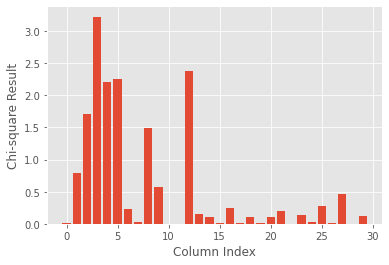

In [34]:
plt.bar([i for i in range(30)], fs.scores_[:30])
plt.xlabel('Column Index')
plt.ylabel('Chi-square Result')
plt.savefig('chi-square_result.png')
plt.show()

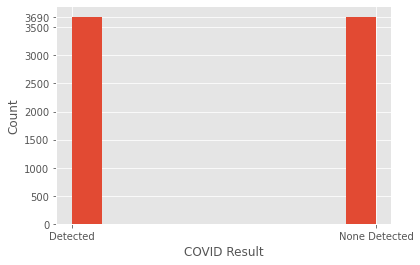

In [33]:
value = []
for i in range(3690):
    value.append('Detected')
for i in range(3690):
    value.append('None Detected')
    
plt.hist(value)
plt.yticks([i for i in range(0, 4000, 500)] + [3690])
plt.xlabel('COVID Result')
plt.ylabel('Count')
plt.savefig('generated_data_distribution.png')
plt.show()

***
## 5. Logistic Regression on Selected Feature

### 5.0 Setup

In [275]:
idx = []
for i in scores:
    idx.append(i[0][0])

### 5.1 Top 10 Features

In [276]:
x_train_10 = x_train[:, idx[:10]]
x_test_10 = x_test[:, idx[:10]]

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train_10, y_train)
y_pred_10 = lr.predict(x_test_10)
evaluation(y_test, y_pred_10)

Confusion matrix:
[[1268  117]
 [  52   39]]
Accuracy: 88.55%
Precision: 25.00%
Recall: 42.86%
F1 score: 31.58%


### 5.2 Top 20 Features

In [277]:
x_train_20 = x_train[:, idx[:20]]
x_test_20 = x_test[:, idx[:20]]

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train_20, y_train)
y_pred_20 = lr.predict(x_test_20)
evaluation(y_test, y_pred_20)

Confusion matrix:
[[1248  137]
 [  51   40]]
Accuracy: 87.26%
Precision: 22.60%
Recall: 43.96%
F1 score: 29.85%


### 5.3 Top 30 Features

In [278]:
x_train_30 = x_train[:, idx[:30]]
x_test_30 = x_test[:, idx[:30]]

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train_30, y_train)
y_pred_30 = lr.predict(x_test_30)
evaluation(y_test, y_pred_30)

Confusion matrix:
[[1246  139]
 [  50   41]]
Accuracy: 87.20%
Precision: 22.78%
Recall: 45.05%
F1 score: 30.26%


---
## 6. Bagging

### 6.1 Bagging Classifier with Logistic Regression

In [279]:
clf = BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'))
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[1241  144]
 [  49   42]]
Accuracy: 86.92%
Precision: 22.58%
Recall: 46.15%
F1 score: 30.32%


### 6.2 Balanced Bagging Classifier with Logistic Regression

In [280]:
bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(x_train, y_train)
y_pred = bbc.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[  29 1356]
 [   0   91]]
Accuracy: 8.13%
Precision: 6.29%
Recall: 100.00%
F1 score: 11.83%


---
## 7. Boosting

### 7.1 Gradient Boosting Classifier

In [281]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[1217  168]
 [  62   29]]
Accuracy: 84.42%
Precision: 14.72%
Recall: 31.87%
F1 score: 20.14%
